In [1]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 315M/331M [00:03<00:00, 88.6MB/s]
100% 331M/331M [00:03<00:00, 94.3MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [1]:
import os
import numpy as np
from keras.utils.np_utils import to_categorical
import cv2
import imageio

In [2]:
images = []
labels = []

In [3]:
DIRECTORY = "/content/UTKFace/"
for image in os.listdir(DIRECTORY):
  path = DIRECTORY+image
  gender = path.split('/')[-1].split('_')[1]
  face = imageio.imread(path)
  face = cv2.resize(face, (85, 85))
  images.append(face)
  labels.append(int(gender))

In [4]:
print("X : ", len(images))
print("Y : ", len(labels))

X :  23708
Y :  23708


In [5]:
X = np.array(images)
Y = np.array(labels)

X = X.astype('float32')

In [6]:
X[0].shape

(85, 85, 3)

In [7]:
X_data = np.squeeze(X)
X_data.shape

(23708, 85, 85, 3)

In [8]:
X_data /= 255

In [9]:
Y_data = to_categorical(Y, num_classes=2)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

In [12]:
print(X_train.shape)

(18966, 85, 85, 3)


In [13]:
print(y_train.shape)

(18966, 2)


In [14]:
print(X_test.shape)

(4742, 85, 85, 3)


In [15]:
print(y_test.shape)

(4742, 2)


In [16]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(85, 85, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 85, 85, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)      

In [20]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [21]:
model.fit(X_train,
         y_train,
         batch_size=64,
         epochs=15,
         validation_data=(X_test, y_test),)

Epoch 1/15
297/297 [==============================] - 7s 14ms/step - loss: 0.4920 - accuracy: 0.7575 - val_loss: 0.3384 - val_accuracy: 0.8480
Epoch 2/15
297/297 [==============================] - 4s 13ms/step - loss: 0.3271 - accuracy: 0.8524 - val_loss: 0.3271 - val_accuracy: 0.8518
Epoch 3/15
297/297 [==============================] - 4s 13ms/step - loss: 0.2778 - accuracy: 0.8796 - val_loss: 0.2511 - val_accuracy: 0.8969
Epoch 4/15
297/297 [==============================] - 4s 13ms/step - loss: 0.2529 - accuracy: 0.8914 - val_loss: 0.2458 - val_accuracy: 0.8996
Epoch 5/15
297/297 [==============================] - 4s 13ms/step - loss: 0.2349 - accuracy: 0.9001 - val_loss: 0.2499 - val_accuracy: 0.8962
Epoch 6/15
297/297 [==============================] - 4s 14ms/step - loss: 0.2170 - accuracy: 0.9076 - val_loss: 0.2349 - val_accuracy: 0.8965
Epoch 7/15
297/297 [==============================] - 4s 13ms/step - loss: 0.2042 - accuracy: 0.9135 - val_loss: 0.2411 - val_accuracy: 0.8971

In [22]:
model.save('gender.h5')

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!cp "/content/gender.h5" "/content/drive/MyDrive"

In [24]:
# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9008857011795044


In [25]:
labels =["Male",  # index 0
        "Female",      # index 1
        ]
print('Male ->', '0', '\nFemale ->', '1')

Male -> 0 
Female -> 1


In [26]:
import matplotlib.pyplot as plt

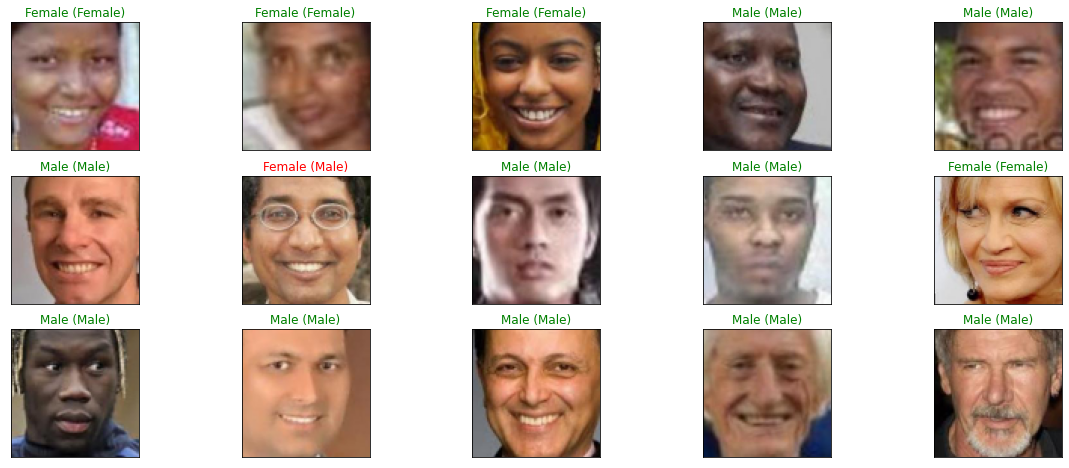

In [29]:
y_hat = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()